In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob


In [2]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
gam_path = "/home/haue/repositories/Masters/data/gamma/Al/newEgwith/"

#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
gam_files = glob.glob(os.path.join(gam_path, "*mlio.root"))

#Files to be analyzed 
Analysis_files = gam_files


In [8]:
# Define gamma gates and their background regions
peak_gates = {
    "332": [(322, 346), (346, 372)],
    #"365": [(355,365), (365, 375)],
    "511": [(505,515), (515,525)],
    #"580": [(575,585), (585, 595)],
    "1113": [(1090,1120), (1120,1150)],
    "1247": [(1235, 1255), (1245, 1265)],
    #"1280": [(1275, 1285), (1265, 1275), (1285, 1295)],
    "1384": [(1366,1396), (1396,1426)],
    #"1460": [(, 965), (905, 935), (965, 995)],
    #"1590": [(1580, 1600), (1560,1580), (1580,1600)],
    "1634": [(1620,1650), (1590,1620), (1650,1680)],
    #"1716": [(1705,1735), (1675,1705), (1765,1795)],
    #"1745": [(1735,1765), (1675,1705), (1765,1795)],
    #"2497": [(2480,2510), (2450,2480), (2510,2540)],
    #"2830": [(2810,2840), (2780,2810), (2840,2870)],

    # can add more gates...
}



ggammas = {}
region_labels = ["gate", "upper_bg"]

for gate_name, peak_ranges in peak_gates.items():
    Eg_list = [np.array([]) for _ in peak_ranges]

    for i, (low, high) in enumerate(peak_ranges):
        for batch in uproot.iterate(
            Analysis_files,
            expressions=["Eg"],
        #cut="pg"
        ):
            #pg = batch["pg"]
            Eg = batch["Eg"]

            # Create mask for values inside gate
            in_gate_mask = (Eg > low) & (Eg < high)

            # Select events where any Eg entry passes gate (axis=1)
            """
            Eg is given like
            [
            [300, 325, 350],    # event 0 has 3 entries
            [310],             # event 1 has 1 entry
            [340, 360, 370, 380] # event 2 has 4 entries
            ...]
            where each array is an event
            when masking one gets
            [
            [False, True, False],
            [False],
            [True, False, False, False],
            ...]
            axis=1 then returns the inner arrays to a single boolean per event
            
            """
            event_mask = ak.any(in_gate_mask, axis=1)

            # Events where condition is true
            gated_Eg = Eg[event_mask]
            gate_mask = in_gate_mask[event_mask]

            # Exclude Eg values that are in the gate
            cleaned_Eg = gated_Eg[~gate_mask]

            # Append flattened to array
            Eg_list[i] = np.append(Eg_list[i], ak.flatten(cleaned_Eg).to_numpy())

    # Remove NaNs (optional cleanup)
    Eg_list = [arr[~np.isnan(arr)] for arr in Eg_list]

    # Save results
    ggammas[gate_name] = {
        region_labels[i]: Eg_list[i] for i in range(len(region_labels))
    }
    print(f"Gamma-gamma gate: {gate_name} processed successfully!")

Gamma-gamma gate: 332 processed successfully!
Gamma-gamma gate: 511 processed successfully!
Gamma-gamma gate: 1113 processed successfully!
Gamma-gamma gate: 1247 processed successfully!
Gamma-gamma gate: 1384 processed successfully!
Gamma-gamma gate: 1634 processed successfully!


In [4]:
####plotter function

def plot_energy_hists(
    energies_list,          # list of arrays of energies (in eV)
    reference_overlay=None, # overlay of comparison spectra
    colors=None,            # list of colors matching energies_list
    labels=None,            # list of labels matching energies_list
    bin_width=0.01,         # bin width in MeV
    scale=None,
    title="Energy Histogram",
    xlabel="Energy (MeV)",
    ylabel="default",
    xlim=(0.25, 3),
    fig_ax=None             # optionally pass existing (fig, ax)
):
    """
    Plot one or more energy histograms on the same figure with consistent formatting.

    Parameters:
    - energies_list: list of np.arrays, each containing energies (in eV)
    - colors: list of color strings (same length as energies_list), default black if None
    - labels: list of labels (same length as energies_list), default None (no legend)
    - bin_width: float, bin width in MeV
    - title, xlabel, ylabel: strings for the plot
    - xlim: tuple, x-axis limits
    - fig_ax: tuple (fig, ax) if you want to add to existing plot, else None to create new

    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    bins = np.arange(0, 3 + bin_width, bin_width)
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
    else:
        fig, ax = fig_ax
    
    if colors is None:
        colors = ['k'] * len(energies_list)
    if labels is None:
        labels = [None] * len(energies_list)
    
    for energies, color, label in zip(energies_list, colors, labels):
        ax.hist(np.array(energies) / 1e3, bins=bins, histtype='step',
                edgecolor=color, color='white', lw=1, label=label)
    
    if reference_overlay is not None:
        overlay_bins = np.arange(0, 3 + 0.01, 0.01)  # fixed 10 keV bins (0.01 MeV)
        ref_hist, ref_edges = np.histogram(np.array(reference_overlay) / 1e3, bins=overlay_bins)
        ref_hist = ref_hist.astype(float)
        ref_max = ref_hist.max()

        # Find max count from main histograms (already computed as global_max later, but for clarity compute here)
        main_max = max([np.histogram(np.array(e) / 1e3, bins=bins)[0].max() for e in energies_list])

        if ref_max > 0:
            # Scale reference histogram only if main max < 1e2
            if main_max < 1e3:
                scale_factor = 1e3 / ref_max
            else:
                scale_factor = main_max / ref_max
            ref_hist_scaled = ref_hist * scale_factor

            ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
            ax.plot(ref_bin_centers, ref_hist_scaled, color='r', ls='--', label='Proton spectrum', linewidth=1)

            
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0, 3, 0.25))
    ax.set_xlim(*xlim)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    
    if ylabel=="default":
        ax.set_ylabel(f"Counts / {int(bin_width*1000)} keV", fontsize=16)
    else:
        ax.set_ylabel(ylabel, fontsize=16)
    global_max = 0
    for energies in energies_list:
        hist, _ = np.histogram(np.array(energies) / 1e3, bins=bins)
        current_max = hist.max()
        if current_max > global_max:
            global_max = current_max

    # Set log scale and y-limits AFTER main histograms, BEFORE overlay
    if scale!=None:
        ymax = max(global_max, scale)*1.1
    else:
        ymax = max(global_max, 1e3) * 1.1  # Use at least 1e2, scaled a bit
    ax.set_ylim(1,ymax)
    if any(labels):
        ax.legend()
    
    return fig, ax


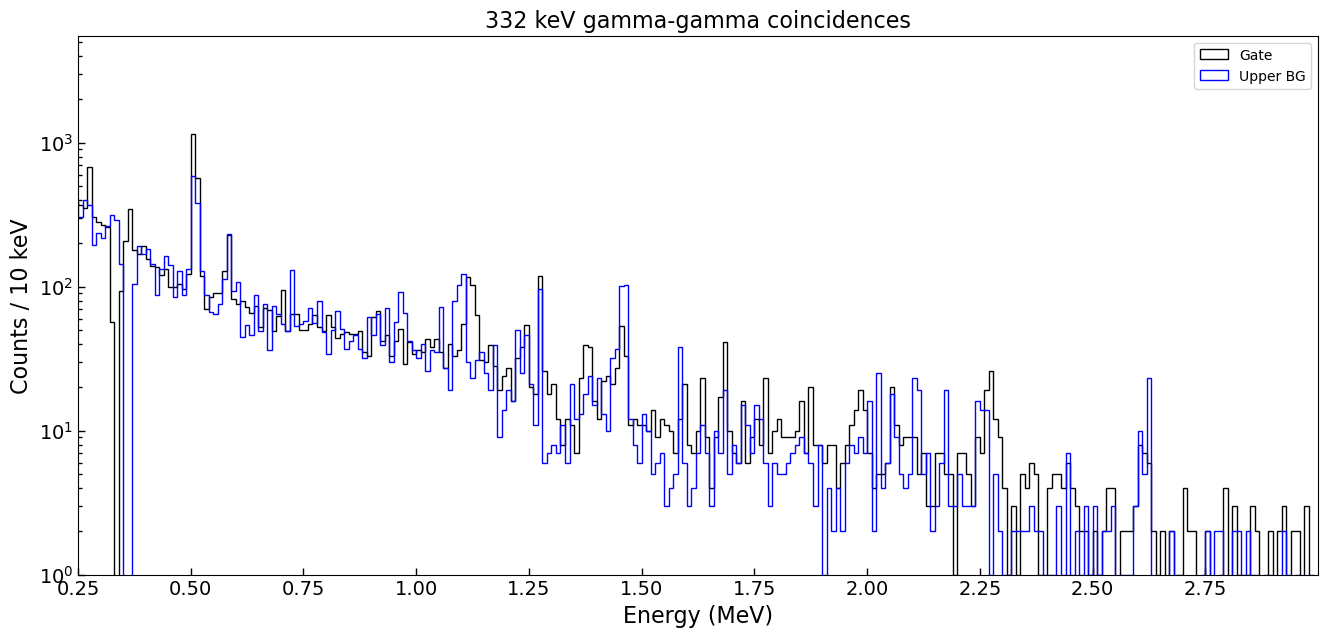

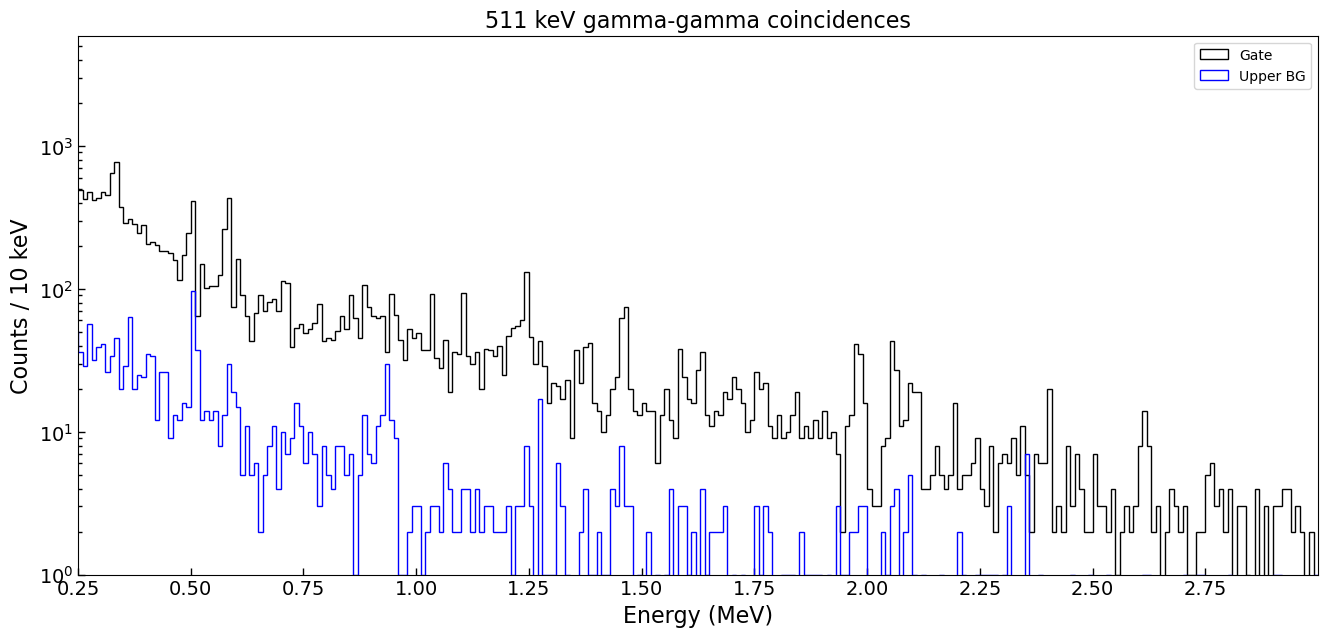

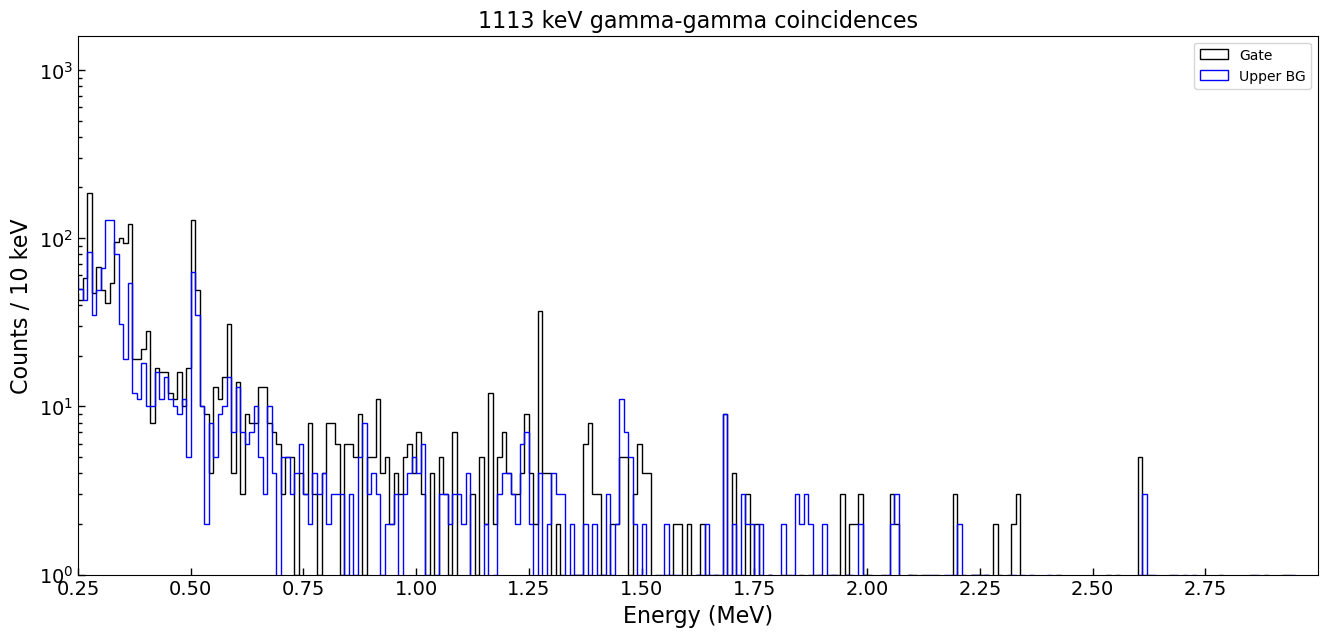

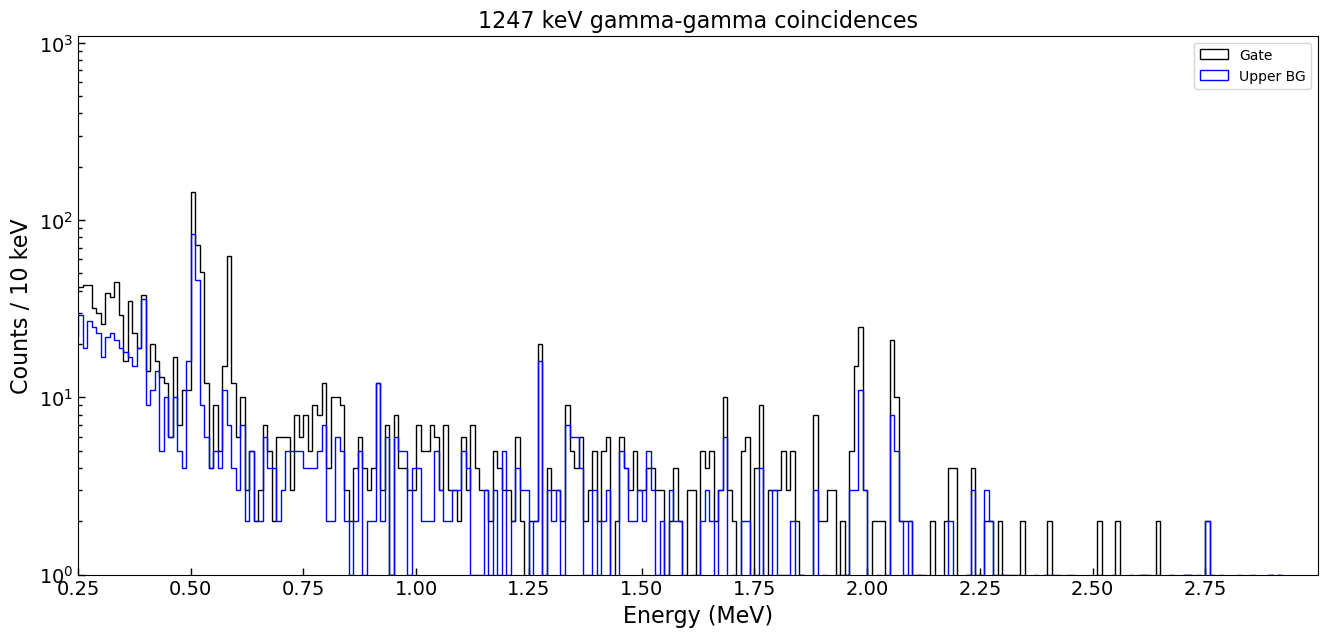

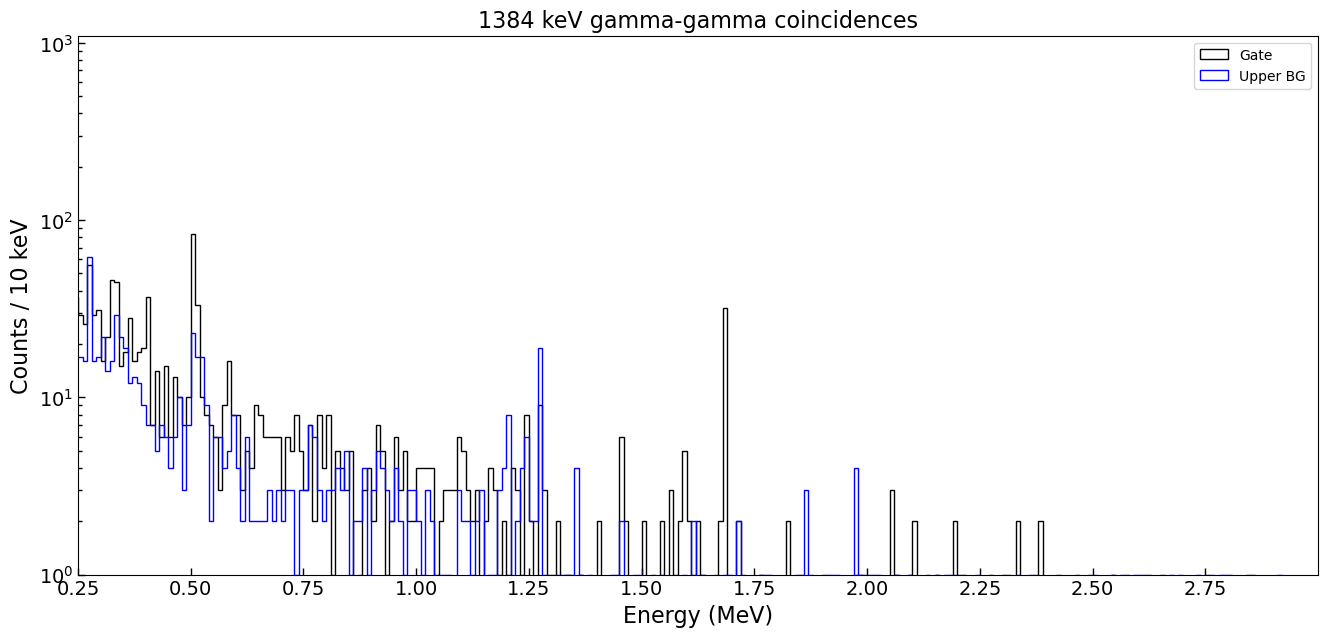

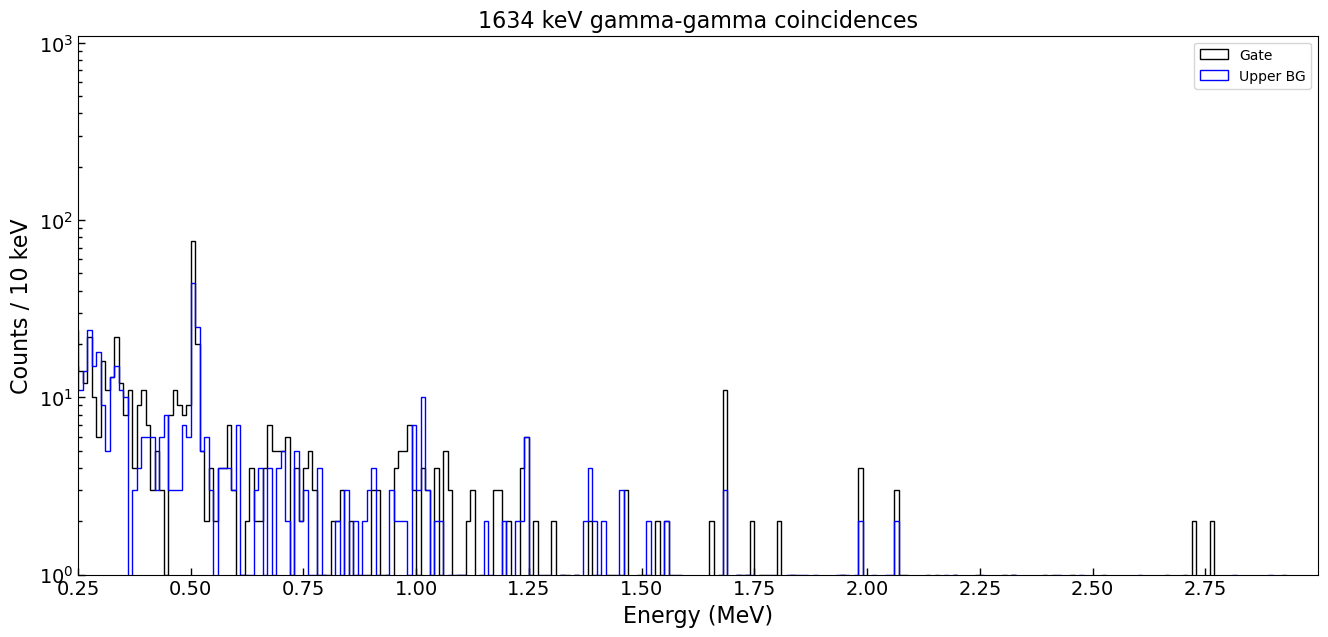

In [9]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [332, 511, 1113,1247,1384,1634]
binwidth = [0.02, 0.03, 0.03, 0.03, 0.03,1,1]
for g,b in zip(gates,binwidth):
    
    fig, ax = plot_energy_hists(
        energies_list=[ggammas[f"{g}"]["gate"], ggammas[f"{g}"]["upper_bg"]],
        reference_overlay = None,
        colors=['k', 'b', 'r'],
        labels=['Gate','Upper BG'],
        bin_width=0.01,
        scale=None,
        title=f"{g} keV gamma-gamma coincidences",
    )
    plt.show()
